In [52]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def calc_and_add_accel(dataframe):
    acceleration = []
    for i in range(dataframe.shape[0]):
        fa = dataframe['frontal accel'][i]
        la = dataframe['lateral accel'][i]
        va = dataframe['vertical accel'][i]

        accel_vector = np.sqrt(fa**2 + la**2 + va**2)
        acceleration.append(accel_vector)

    dataframe['acceleration'] = acceleration
    return dataframe

df_list = []

def add_patient(file, gender, room):
    df = pd.read_csv(file, header=None)
    df.columns = [
        'time',
        'frontal accel',
        'vertical accel',
        'lateral accel',
        'antenna id',
        'rssi',
        'phase',
        'frequency',
        'activity',
    ]
    df['gender'] = gender
    df['room'] = room
    calc_and_add_accel(df)
    df_list.append(df)

for file in sorted(glob.glob('../S1_Dataset/d1p*F')):
    add_patient(file, 0, 1)

for file in sorted(glob.glob('../S1_Dataset/d1p*M')):
    add_patient(file, 1, 1)

for file in sorted(glob.glob('../S2_Dataset/d2p*F')):
    add_patient(file, 0, 2)

for file in sorted(glob.glob('../S2_Dataset/d2p*M')):
    add_patient(file, 1, 2)

df = pd.concat(df_list, axis=0, ignore_index=True)
df.replace({'activity': {1: 0, 2: 0, 3: 0, 4: 1}}, inplace=True)

In [53]:
import matplotlib.patches as mpatches

colors = {
    0: 'C0',
    1: 'C1',
}

legend = [
    mpatches.Patch(color='C0', label='inactive'),
    mpatches.Patch(color='C1', label='active'),
]

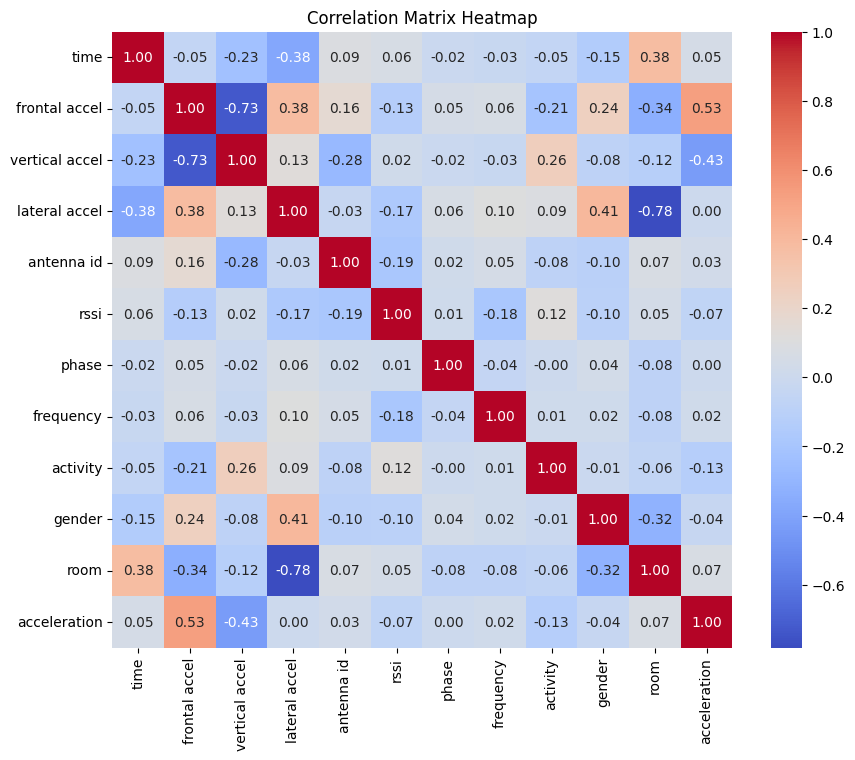

In [54]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [55]:
def plot3D(df, legend=legend):
    xname = 'frontal accel'
    yname = 'lateral accel'
    zname = 'vertical accel'
    x = df[xname]
    y = df[yname]
    z = df[zname]
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c=df['activity'].map(colors))
    # ax.set_title(f"activity vs acceleration")
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_zlabel(zname)
    ax.zaxis.labelpad = -0.7
    if legend != None:
        ax.legend(handles=legend)
    plt.tight_layout()
    plt.show()

In [56]:
def plot_accel_vs_accel(df, legend=legend):
    plt.figure(figsize=(12, 12))

    xname = 'vertical accel'
    yname = 'frontal accel'
    x = df[xname]
    y = df[yname]
    plt.subplot(3, 3, 1)
    plt.scatter(x, y, c=df['activity'].map(colors))
    # plt.title(f"{yname} vs {xname}")
    plt.xlabel(xname)
    plt.ylabel(yname)
    if legend != None:
        plt.legend(handles=legend, fontsize=6)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=0, color='gray', linestyle='--')

    xname = 'lateral accel'
    yname = 'frontal accel'
    x = df[xname]
    y = df[yname]
    plt.subplot(3, 3, 2)
    plt.scatter(x, y, c=df['activity'].map(colors))
    # plt.title(f"{yname} vs {xname}")
    plt.xlabel(xname)
    plt.ylabel(yname)
    if legend != None:
        plt.legend(handles=legend, fontsize=6)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=0, color='gray', linestyle='--')

    xname = 'lateral accel'
    yname = 'vertical accel'
    x = df[xname]
    y = df[yname]
    plt.subplot(3, 3, 3)
    plt.scatter(x, y, c=df['activity'].map(colors))
    # plt.title(f"{yname} vs {xname}")
    plt.xlabel(xname)
    plt.ylabel(yname)
    if legend != None:
        plt.legend(handles=legend, fontsize=6)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=0, color='gray', linestyle='--')

    plt.tight_layout()
    plt.show()

In [57]:
df

,time,frontal accel,vertical accel,lateral accel,antenna id,rssi,phase,frequency,activity,gender,room,acceleration
0,0.00,0.51826,0.89339,0.134560,4,-56.5,5.83680,921.75,0,0,1,1.041559
1,0.25,0.51826,0.89339,0.134560,3,-68.0,4.84120,925.75,0,0,1,1.041559
2,0.75,0.51826,0.89339,0.134560,4,-55.5,3.64170,924.25,0,0,1,1.041559
3,1.25,0.51826,0.89339,0.134560,3,-57.5,1.77790,924.75,0,0,1,1.041559
4,1.75,0.51826,0.89339,0.134560,4,-61.5,0.24083,922.75,0,0,1,1.041559
...,...,...,...,...,...,...,...,...,...,...,...,...
75123,532.00,0.57689,0.88191,0.134560,3,-62.5,3.76290,922.75,0,1,2,1.062391
75124,532.25,0.57689,0.88191,0.134560,2,-63.5,5.60210,924.75,0,1,2,1.062391
75125,533.50,0.35411,0.96229,0.088944,1,-65.0,0.98175,923.75,0,1,2,1.029226
75126,533.75,0.35411,0.96229,0.088944,3,-60.0,1.46030,922.25,0,1,2,1.029226


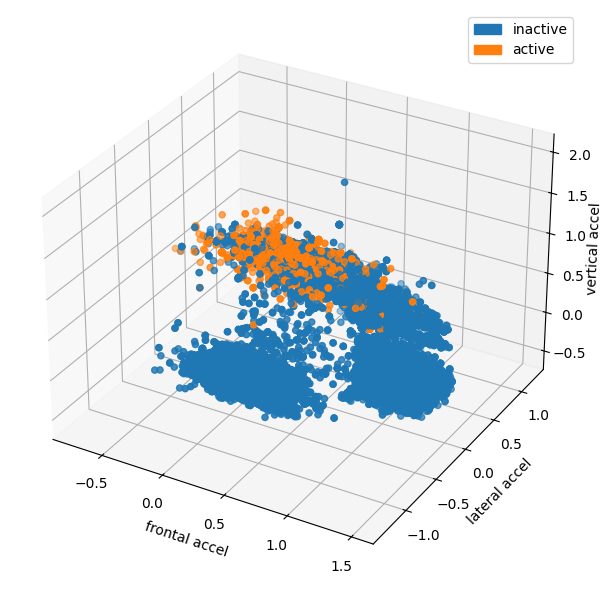

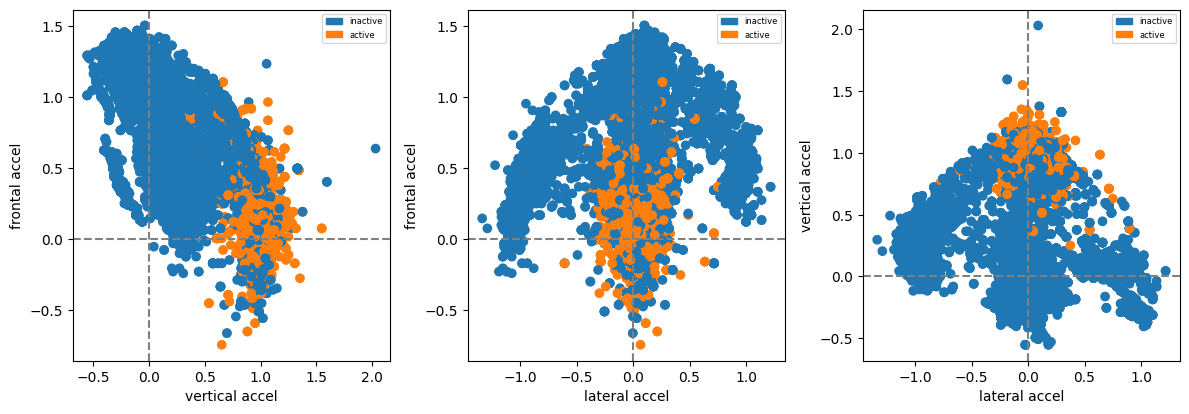

In [58]:
plot3D(df)
plot_accel_vs_accel(df)

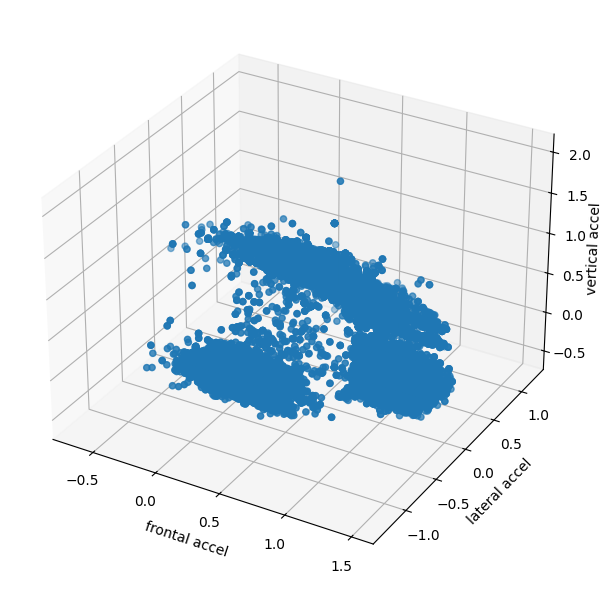

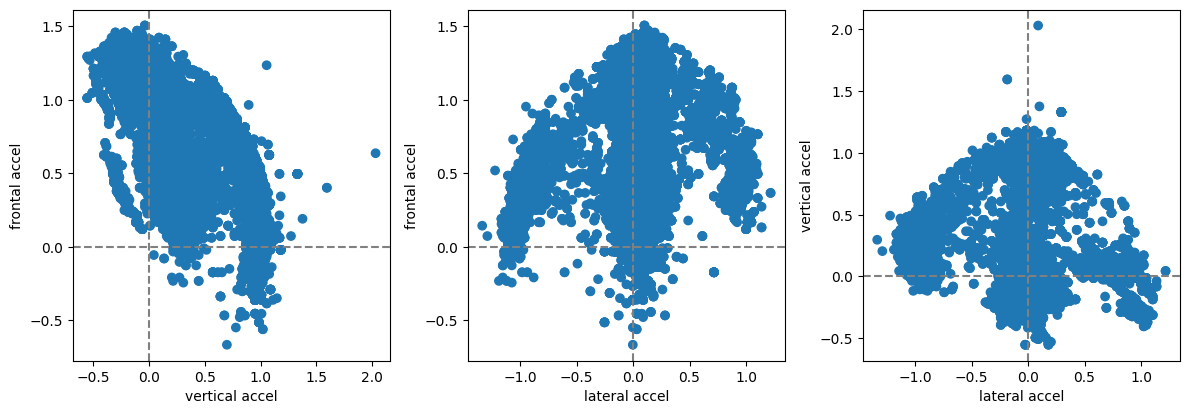

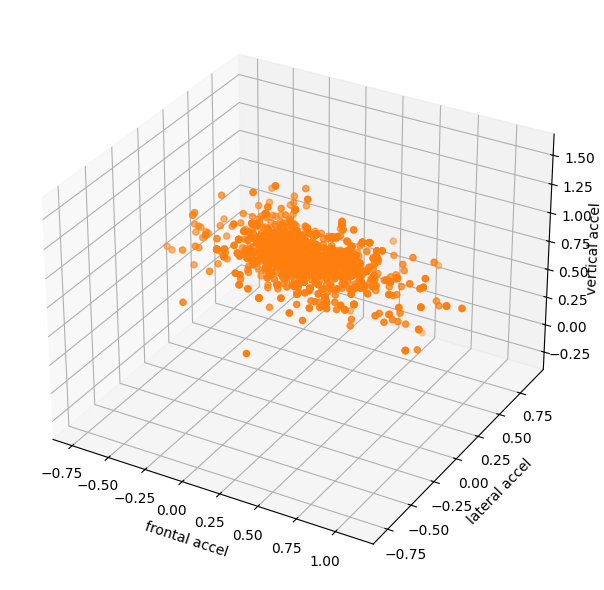

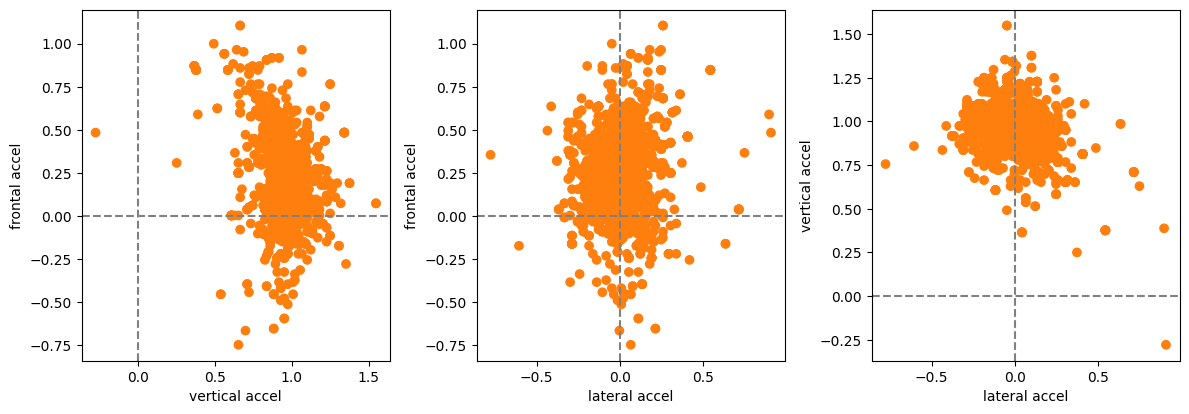

In [59]:
plot3D(df[df['activity'] == 0], legend=None)
plot_accel_vs_accel(df[df['activity'] == 0], legend=None)
plot3D(df[df['activity'] == 1], legend=None)
plot_accel_vs_accel(df[df['activity'] == 1], legend=None)

In [60]:
import joblib
model = joblib.load('../elderly_activity_model.gz')
df_pred = df.drop(columns=['activity'])
predictions = (model.predict(df_pred) >= 0.1792).astype(int)
df_pred.insert(len(df_pred.columns) - 3, 'activity', predictions)
df_pred

  78/2348 [..............................] - ETA: 1s  

2348/2348 [==============================] - 1s 585us/step


,time,frontal accel,vertical accel,lateral accel,antenna id,rssi,phase,frequency,activity,gender,room,acceleration
0,0.00,0.51826,0.89339,0.134560,4,-56.5,5.83680,921.75,0,0,1,1.041559
1,0.25,0.51826,0.89339,0.134560,3,-68.0,4.84120,925.75,0,0,1,1.041559
2,0.75,0.51826,0.89339,0.134560,4,-55.5,3.64170,924.25,0,0,1,1.041559
3,1.25,0.51826,0.89339,0.134560,3,-57.5,1.77790,924.75,0,0,1,1.041559
4,1.75,0.51826,0.89339,0.134560,4,-61.5,0.24083,922.75,0,0,1,1.041559
...,...,...,...,...,...,...,...,...,...,...,...,...
75123,532.00,0.57689,0.88191,0.134560,3,-62.5,3.76290,922.75,0,1,2,1.062391
75124,532.25,0.57689,0.88191,0.134560,2,-63.5,5.60210,924.75,0,1,2,1.062391
75125,533.50,0.35411,0.96229,0.088944,1,-65.0,0.98175,923.75,0,1,2,1.029226
75126,533.75,0.35411,0.96229,0.088944,3,-60.0,1.46030,922.25,0,1,2,1.029226


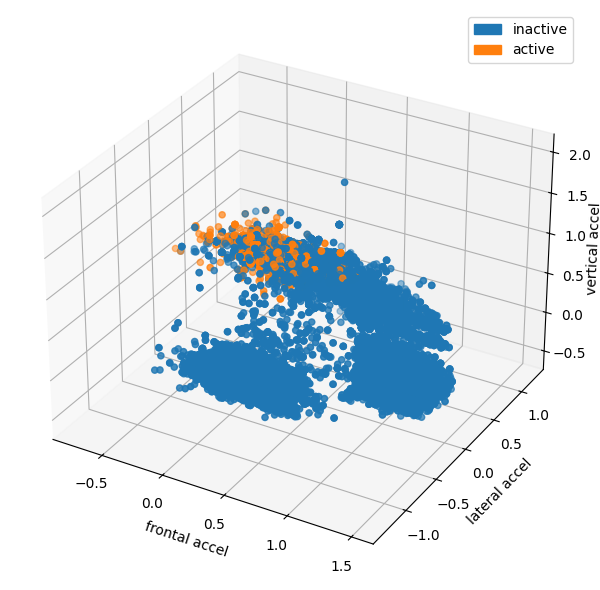

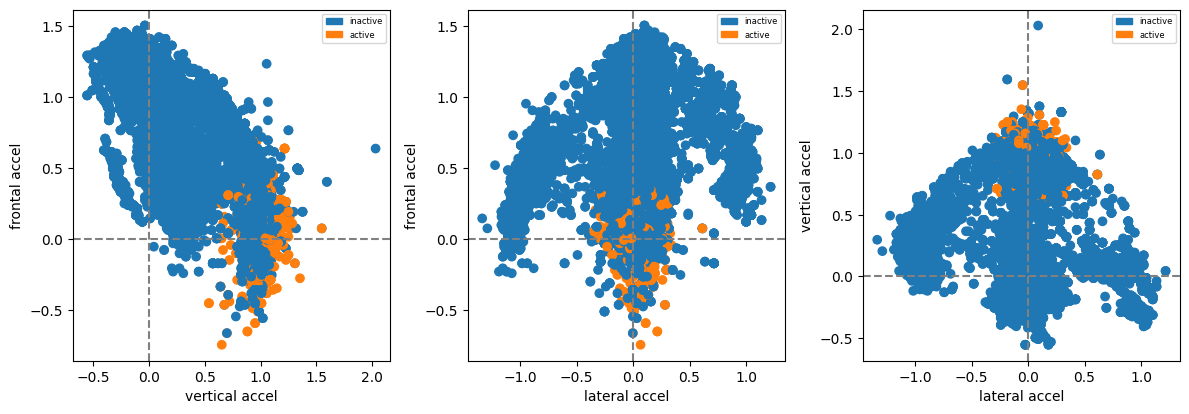

In [61]:
plot3D(df_pred)
plot_accel_vs_accel(df_pred)

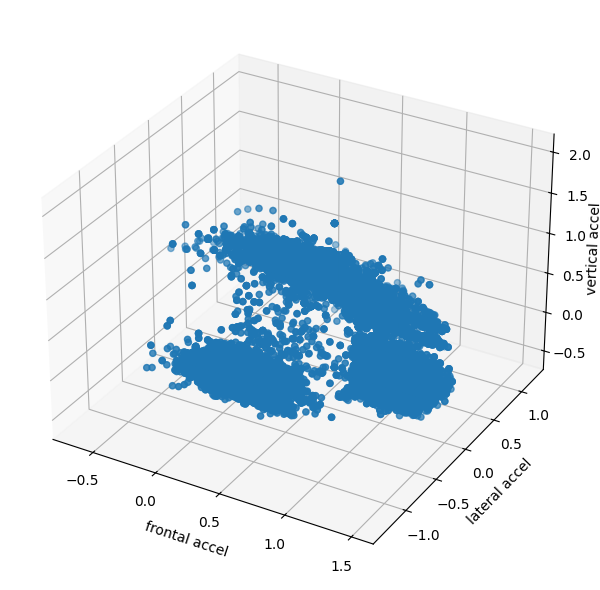

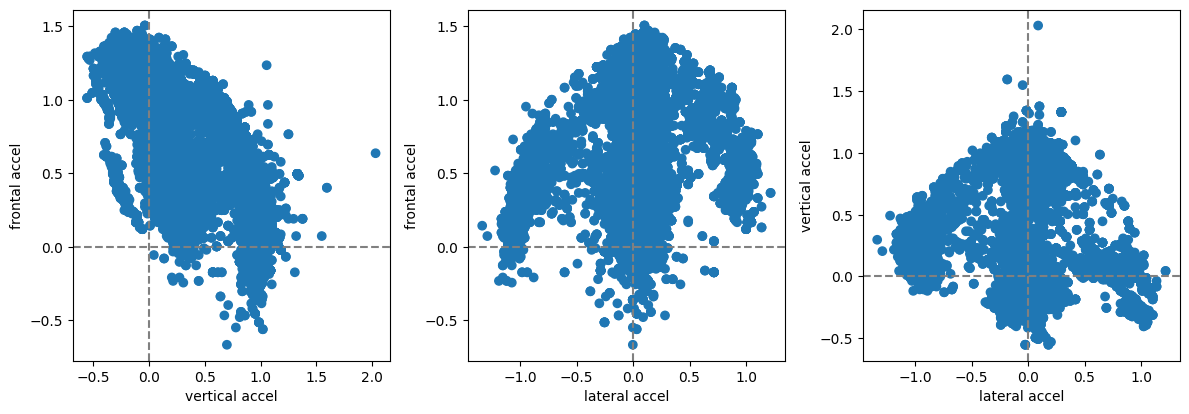

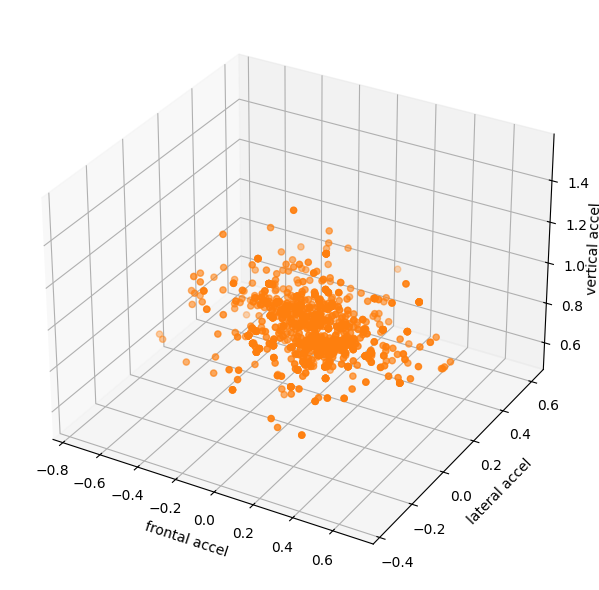

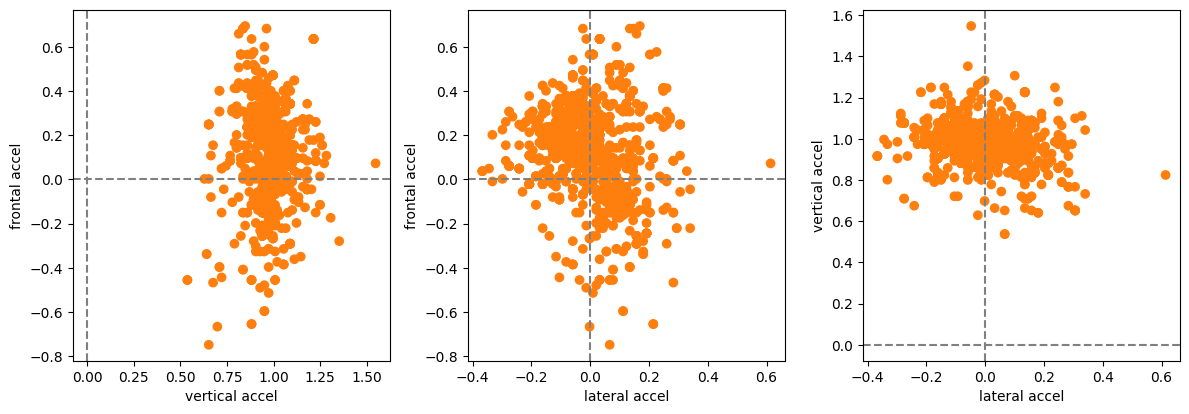

In [62]:
plot3D(df_pred[df_pred['activity'] == 0], legend=None)
plot_accel_vs_accel(df_pred[df_pred['activity'] == 0], legend=None)
plot3D(df_pred[df_pred['activity'] == 1], legend=None)
plot_accel_vs_accel(df_pred[df_pred['activity'] == 1], legend=None)

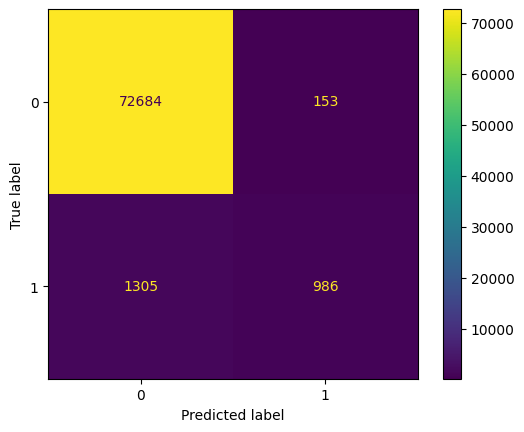

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df['activity'], df_pred['activity'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()